In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from copy import copy
import datetime
import pickle
from geopy.geocoders import Nominatim
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-whitegrid")
pd.pandas.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<ipython-input-2-8963ae997e1c>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
sample_df = pd.read_csv("/content/drive/MyDrive/nyc_taxi_trip_duration.csv")
sample_df.shape

(729322, 11)

In [ ]:
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


# **Preprocessing**

In [ ]:
sample_df["store_and_fwd_flag"].value_counts()

N    725282
Y      4040
Name: store_and_fwd_flag, dtype: int64

In [ ]:
#Convert character variables to numeric
f = lambda x: 0 if x == 'N' else 1

sample_df["store_and_fwd_flag"] = sample_df["store_and_fwd_flag"].apply(lambda x: f(x))

In [ ]:
#Check result
sample_df["store_and_fwd_flag"].value_counts()

0    725282
1      4040
Name: store_and_fwd_flag, dtype: int64

In [ ]:
#First, convert datetime strings into datetime
sample_df["dropoff_datetime"] = pd.to_datetime(sample_df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
sample_df["pickup_datetime"] = pd.to_datetime(sample_df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#Now construct other variables, like month, date, etc.
sample_df["pickup_month"] = sample_df["pickup_datetime"].dt.month
sample_df["pickup_day"] = sample_df["pickup_datetime"].dt.day
sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday #sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
sample_df["pickup_hour"] = sample_df["pickup_datetime"].dt.hour
sample_df["pickup_minute"] = sample_df["pickup_datetime"].dt.minute

In [ ]:
#Get latitude and longitude differences
sample_df["latitude_difference"] = sample_df["dropoff_latitude"] - sample_df["pickup_latitude"]
sample_df["longitude_difference"] = sample_df["dropoff_longitude"] - sample_df["pickup_longitude"]

In [ ]:
#Convert duration to minutes for easier interpretation
sample_df["trip_duration"] = sample_df["trip_duration"].apply(lambda x: round(x/60))

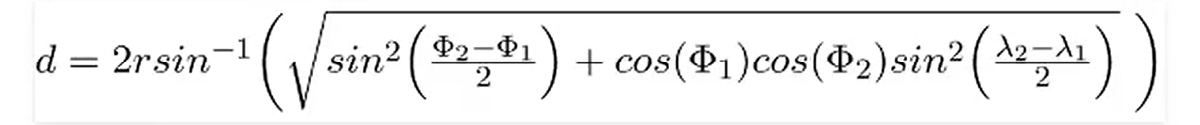

In [ ]:
#Convert trip distance from longitude and latitude differences to Manhattan distance.
sample_df["trip_distance"]=1000 * 6371 * 2 * np.arcsin(
    np.sqrt(
        np.sin(sample_df['latitude_difference']/2)**2
        + np.cos(sample_df['pickup_latitude'])
        * np.cos(sample_df['dropoff_latitude'])
        * np.sin(sample_df['longitude_difference']/2)**2
    )
)

In [ ]:
sample_df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,7,2,29,0,16,40,-0.007710,-0.009956,80117.181070
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,18,3,11,4,23,35,-0.036812,-0.006439,238031.703184
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,27,2,21,6,17,59,0.053459,0.049286,462310.625326
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,19,1,5,1,9,44,0.020908,0.004890,136784.658438
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,14,2,17,2,6,42,0.032162,0.028938,274801.993113
5,id1918069,2,2016-02-14 18:31:42,2016-02-14 18:55:57,2,-73.993614,40.751884,-73.995422,40.723862,0,24,2,14,6,18,31,-0.028023,-0.001808,178900.381942
6,id2429028,1,2016-04-20 20:30:14,2016-04-20 20:36:51,1,-73.965080,40.758915,-73.976807,40.764107,0,7,4,20,2,20,30,0.005192,-0.011726,81489.515968
7,id1663798,2,2016-06-19 16:48:14,2016-06-19 17:06:35,1,-73.963890,40.765434,-73.872429,40.774200,0,18,6,19,6,16,48,0.008766,0.091461,583909.915221
8,id2436943,2,2016-03-28 19:17:03,2016-03-28 19:48:29,2,-73.872887,40.774281,-73.979019,40.761879,0,31,3,28,0,19,17,-0.012402,-0.106133,678994.401189
9,id2933909,1,2016-04-10 22:01:41,2016-04-10 22:25:30,1,-73.987823,40.740982,-73.999153,40.686451,0,24,4,10,6,22,1,-0.054531,-0.011330,354717.111547


# **XGBoost Model**

In [ ]:
X = sample_df.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
y = sample_df["trip_duration"]

In [ ]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [ ]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [ ]:
#XGBoost parameters
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [ ]:
nrounds = 2000

In [ ]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

#this is for tracking the error
watchlist = [(dval, 'eval'), (dtrain, 'train')]

In [ ]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )


[10:00:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:00:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feval", "silent" } are not used.

[0]	eval-rmse:2.00673	train-rmse:2.00666
[1]	eval-rmse:1.91090	train-rmse:1.91067
[2]	eval-rmse:1.82182	train-rmse:1.82152
[3]	eval-rmse:1.73518	train-rmse:1.73483
[4]	eval-rmse:1.65398	train-rmse:1.65354
[5]	eval-rmse:1.57604	train-rmse:1.57534
[6]	eval-rmse:1.50257	train-rmse:1.50154
[7]	eval-rmse:1.43268	train-rmse:1.43153
[8]	eval-rmse:1.36675	train-rmse:1.36523
[9]	eval-rmse:1.30388	train-rmse:1.30199
[10]	eval-rmse:1.24534	train-rmse:1.24324
[11]	eval-rmse:1.18951	train-rmse:1.18689
[12]	eval-rmse:1.13676	train-rmse:1.13359
[13]	eval-rmse:1.08643	train-rmse:1.08296
[14]	eval-rmse:1.03922	train-rmse:1.03520
[15]	eval-rmse:0.99431	train-rmse:0.98972
[16]	eval-rmse:0.95185	train-rmse:0.94654
[17]	eval-rmse:0.91240	train-rmse:0.90660
[18]	eval-rmse:0.87473	train-rmse:0.86839


In [ ]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [ ]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

4.372640513466676

In [ ]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'passenger_count': 198556.0,
 'pickup_longitude': 690639.0,
 'pickup_latitude': 617892.0,
 'dropoff_longitude': 512192.0,
 'dropoff_latitude': 492163.0,
 'store_and_fwd_flag': 3842.0,
 'pickup_month': 172408.0,
 'pickup_day': 311953.0,
 'pickup_weekday': 179114.0,
 'pickup_hour': 275554.0,
 'pickup_minute': 312151.0,
 'latitude_difference': 376487.0,
 'longitude_difference': 370080.0,
 'trip_distance': 339737.0}

In [ ]:
#This is not very telling, so let's scale the features
summ = 0
for key in feature_scores:
    summ = summ + feature_scores[key]

for key in feature_scores:
    feature_scores[key] = feature_scores[key] / summ

feature_scores

{'passenger_count': 0.04091602977929297,
 'pickup_longitude': 0.142318569525681,
 'pickup_latitude': 0.12732774367124083,
 'dropoff_longitude': 0.10554636034527098,
 'dropoff_latitude': 0.1014190251831532,
 'store_and_fwd_flag': 0.0007917131006468885,
 'pickup_month': 0.03552776477259988,
 'pickup_day': 0.06428351819003093,
 'pickup_weekday': 0.03690965650943956,
 'pickup_hour': 0.05678285052984194,
 'pickup_minute': 0.0643243196460247,
 'latitude_difference': 0.0775819078925677,
 'longitude_difference': 0.07626163047563782,
 'trip_distance': 0.07000891037857157}

In [ ]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))

## **Optimization Algorithm**

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#Sample date

date_list = [4, 6, 2016] #April 6, 2016

year = int(date_list[2])
month = int(date_list[1])
day = int(date_list[0])

my_date = datetime.date(year, month, day)

In [ ]:
#Sample test locations

test_locations = {'L1': (40.819688, -73.915091),
                  'L2': (40.815421, -73.941761),
                  'L3': (40.764198, -73.910785),
                  'L4': (40.768790, -73.953285),
                  'L5': (40.734851, -73.952950),
                  'L6': (40.743613, -73.977998),
                  'L7': (40.745313, -73.993793),
                  'L8': (40.662713, -73.946101),
                  'L9': (40.703761, -73.886496),
                  'L10': (40.713620, -73.943076),
                  'L11': (40.725212, -73.809179)
             }

In [ ]:
geolocator = Nominatim(user_agent = "test")
addresses = []

for key in test_locations:
    location = geolocator.reverse(test_locations[key])
    addresses.append(location.address)

In [ ]:
addresses

['424, East 155th Street, Melrose, Bronx County, City of New York, New York, 10455, United States',
 '137, West 136th Street, Harlem, Manhattan, New York County, City of New York, New York, 10030, United States',
 'Citi Bike - 28 Av / 44 St, 28th Avenue, Queens, City of New York, New York, 11377, United States',
 '435, East 74th Street, Lenox Hill, Manhattan, New York County, City of New York, New York, 10021, United States',
 '211, Freeman Street, Brooklyn, Kings County, City of New York, New York, 11222, United States',
 '232, East 32nd Street, Manhattan Community Board 6, Manhattan, New York County, City of New York, New York, 10016, United States',
 '159, West 25th Street, Chelsea, Manhattan, New York County, City of New York, New York, 10001, United States',
 '486, Brooklyn Avenue, Crown Heights, Brooklyn, Kings County, City of New York, New York, 11225, United States',
 '70-38, 67th Place, Glendale, Queens, City of New York, New York, 11385, United States',
 '194, Devoe Street, W

In [ ]:
test_addresses = {'L1': '424 East 155th Street NY',
                  'L2': '137 West 136th Street NY',
                  'L3': '43-11 28th Avenue NY',
                  'L4': '435 East 74th Street NY',
                  'L5': '211 Freeman Street NY',
                  'L6': '232 East 32nd Street NY',
                  'L7': '159 West 25th Street NY',
                  'L8': '486 Brooklyn Avenue NY',
                  'L9': '70-38 67th Place NY',
                  'L10': '194 Devoe Street NY',
                  'L11': '158-46 76th Avenue NY'
             }

# **Genetic Algorithm**

In [ ]:
def create_guess(points):
    """
    Creates a possible path between all points, returning to the original.
    Input: List of point IDs
    """
    guess = copy(points)
    np.random.shuffle(guess)
    guess.append(guess[0])
    return list(guess)

create_guess(list(test_locations.keys()))

['L6', 'L1', 'L4', 'L10', 'L8', 'L3', 'L2', 'L7', 'L9', 'L5', 'L11', 'L6']

In [ ]:
def create_generation(points, population=100):
    """
    Makes a list of guessed point orders given a list of point IDs.
    Input:
    points: list of point ids
    population: how many guesses to make
    """
    generation = [create_guess(points) for _ in range(population)]
    return generation

test_generation = create_generation(list(test_locations.keys()), population=10)
print(test_generation)

[['L9', 'L10', 'L5', 'L8', 'L3', 'L11', 'L1', 'L6', 'L4', 'L7', 'L2', 'L9'], ['L7', 'L3', 'L4', 'L2', 'L10', 'L6', 'L11', 'L9', 'L8', 'L1', 'L5', 'L7'], ['L5', 'L10', 'L9', 'L3', 'L4', 'L2', 'L11', 'L8', 'L7', 'L6', 'L1', 'L5'], ['L7', 'L10', 'L2', 'L4', 'L1', 'L5', 'L9', 'L8', 'L11', 'L6', 'L3', 'L7'], ['L4', 'L5', 'L3', 'L11', 'L1', 'L8', 'L2', 'L7', 'L10', 'L9', 'L6', 'L4'], ['L9', 'L10', 'L3', 'L5', 'L1', 'L11', 'L2', 'L6', 'L8', 'L4', 'L7', 'L9'], ['L9', 'L6', 'L10', 'L8', 'L4', 'L7', 'L1', 'L5', 'L11', 'L3', 'L2', 'L9'], ['L6', 'L7', 'L8', 'L5', 'L3', 'L9', 'L10', 'L11', 'L1', 'L4', 'L2', 'L6'], ['L6', 'L4', 'L2', 'L11', 'L7', 'L5', 'L3', 'L9', 'L1', 'L10', 'L8', 'L6'], ['L11', 'L9', 'L3', 'L2', 'L4', 'L6', 'L10', 'L1', 'L7', 'L5', 'L8', 'L11']]


In [ ]:
def travel_time_between_points(point1_id, point2_id, hour, date, passenger_count = 1,
                               store_and_fwd_flag = 0, pickup_minute = 0):
    """
    Given two points, this calculates travel between them based on a XGBoost predictive model
    """

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude' : point1_id[1],
                  'pickup_latitude' : point1_id[0],
                  'dropoff_longitude' : point2_id[1],
                  'dropoff_latitude' : point2_id[0],
                  'store_and_fwd_flag' : store_and_fwd_flag,
                  'pickup_month' : my_date.month,
                  'pickup_day' : my_date.day,
                  'pickup_weekday' : my_date.weekday(),
                  'pickup_hour': hour,
                  'pickup_minute' : pickup_minute,
                  'latitude_difference' : point2_id[0] - point1_id[0],
                  'longitude_difference' : point2_id[1] - point1_id[1],
                  'trip_distance' : 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2))),
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2))),
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2)))))))
                 }

    df = pd.DataFrame([model_data], columns=model_data.keys())

    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1

    return pred[0]

In [ ]:
coordinates = test_locations

In [ ]:
def fitness_score(guess):
    """
    Loops through the points in the guesses order and calculates
    how much distance the path would take to complete a loop.
    Lower is better.
    """
    score = 0
    for ix, point_id in enumerate(guess[:-1]):
        score += travel_time_between_points(coordinates[point_id], coordinates[guess[ix+1]], 11, my_date)
    return score

def check_fitness(guesses):
    """
    Goes through every guess and calculates the fitness score.
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess)))
    return fitness_indicator

print(check_fitness(test_generation))

[(['L9', 'L10', 'L5', 'L8', 'L3', 'L11', 'L1', 'L6', 'L4', 'L7', 'L2', 'L9'], 164.5805492401123), (['L7', 'L3', 'L4', 'L2', 'L10', 'L6', 'L11', 'L9', 'L8', 'L1', 'L5', 'L7'], 156.1955099105835), (['L5', 'L10', 'L9', 'L3', 'L4', 'L2', 'L11', 'L8', 'L7', 'L6', 'L1', 'L5'], 149.73694324493408), (['L7', 'L10', 'L2', 'L4', 'L1', 'L5', 'L9', 'L8', 'L11', 'L6', 'L3', 'L7'], 156.54261779785156), (['L4', 'L5', 'L3', 'L11', 'L1', 'L8', 'L2', 'L7', 'L10', 'L9', 'L6', 'L4'], 160.22760486602783), (['L9', 'L10', 'L3', 'L5', 'L1', 'L11', 'L2', 'L6', 'L8', 'L4', 'L7', 'L9'], 165.97977828979492), (['L9', 'L6', 'L10', 'L8', 'L4', 'L7', 'L1', 'L5', 'L11', 'L3', 'L2', 'L9'], 185.10045623779297), (['L6', 'L7', 'L8', 'L5', 'L3', 'L9', 'L10', 'L11', 'L1', 'L4', 'L2', 'L6'], 156.74377632141113), (['L6', 'L4', 'L2', 'L11', 'L7', 'L5', 'L3', 'L9', 'L1', 'L10', 'L8', 'L6'], 163.0159502029419), (['L11', 'L9', 'L3', 'L2', 'L4', 'L6', 'L10', 'L1', 'L7', 'L5', 'L8', 'L11'], 163.83821296691895)]


In [ ]:
def get_breeders_from_generation(guesses, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]

    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)

    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        ix = np.random.randint(len(guesses))
        new_generation.append(guesses[ix])

    # No mutations here since the order really matters.
    # If we wanted to, we could add a "swapping" mutation,
    # but in practice it doesn't seem to be necessary

    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """
    Take some values from parent 1 and hold them in place, then merge in values
    from parent2, filling in from left to right with cities that aren't already in
    the child.
    """
    list_of_ids_for_parent1 = list(np.random.choice(parent1, replace=False, size=len(parent1)//2))
    child = [-99 for _ in parent1]

    for ix in range(0, len(list_of_ids_for_parent1)):
        child[ix] = parent1[ix]
    for ix, gene in enumerate(child):
        if gene == -99:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    child[-1] = child[0]
    return child

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair.
    If there are an odd number of parent possibilities, one
    will be left out.

    Pairing happens by pairing the first and last entries.
    Then the second and second from last, and so on.
    """
    mid_point = len(old_generation)//2
    next_generation = []

    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
    return next_generation

In [ ]:
current_generation = create_generation(list(test_locations.keys()),population=500)
print_every_n_generations = 5

for i in range(100):
    if not i % print_every_n_generations:
        print("Generation %i: "%i, end='')
        print(len(current_generation))
        is_verbose = True
    else:
        is_verbose = False
    breeders, best_guess = get_breeders_from_generation(current_generation,
                                                        take_best_N=250, take_random_N=100,
                                                        verbose=is_verbose)
    current_generation = make_children(breeders, children_per_couple=3)

Generation 0: 500
['L10', 'L9', 'L1', 'L11', 'L8', 'L3', 'L7', 'L6', 'L2', 'L4', 'L5', 'L10']
Generation 5: 525
['L4', 'L3', 'L10', 'L9', 'L5', 'L7', 'L11', 'L8', 'L2', 'L1', 'L6', 'L4']
Generation 10: 525
['L5', 'L7', 'L1', 'L2', 'L4', 'L6', 'L11', 'L8', 'L9', 'L10', 'L3', 'L5']
Generation 15: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 20: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 25: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 30: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 35: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 40: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 45: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2', 'L3', 'L10', 'L5', 'L7', 'L6', 'L11']
Generation 50: 525
['L11', 'L8', 'L9', 'L4', 'L1', 'L2

In [ ]:
  def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):
    """
    Takes in a generation of guesses then evolves them over time using our breeding rules.
    Continue this for "max_generations" times.
    Inputs:
    current_generation: The first generation of guesses
    max_generations: how many generations to complete
    take_best_N: how many of the top performers get selected to breed
    take_random_N: how many random guesses get brought in to keep genetic diversity
    mutation_rate: How often to mutate (currently unused)
    children_per_couple: how many children per breeding pair
    print_every_n_geneartions: how often to print in verbose mode
    verbose: Show printouts of progress
    Returns:
    fitness_tracking: a list of the fitness score at each generations
    best_guess: the best_guess at the end of evolution
    """
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            #print("Generation %i: "%i, end='')
            #print(len(current_generation))
            #print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation,
                                                            take_best_N=take_best_N, take_random_N=take_random_N,
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess))
        current_generation = make_children(breeders, children_per_couple=children_per_couple)

    return fitness_tracking, best_guess

current_generation = create_generation(list(test_locations.keys()),population=500)
fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, verbose=True)
print(best_guess)

['L8', 'L3', 'L4', 'L2', 'L1', 'L10', 'L9', 'L5', 'L7', 'L6', 'L11', 'L8']
['L1', 'L8', 'L10', 'L5', 'L4', 'L6', 'L7', 'L2', 'L3', 'L9', 'L11', 'L1']
['L1', 'L8', 'L10', 'L5', 'L4', 'L6', 'L7', 'L2', 'L3', 'L9', 'L11', 'L1']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 'L7', 'L2', 'L4', 'L6', 'L1', 'L11', 'L10', 'L3']
['L3', 'L8', 'L9', 'L5', 